In [1]:
! pip install torchvision

In [2]:
#importing required libraries

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
import matplotlib.animation as animation
import random
from random import *
from IPython.display import HTML 

In [4]:
from torch.autograd import Variable
from torchvision.utils import save_image
import os 
import cv2
import torch.backends.cudnn as cudnn

In [5]:
from matplotlib.pyplot import *
from pylab import *
import torchvision.utils as vutils

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [7]:
def to_var(x):
    if torch.cuda.is_available():
        x=x.cuda()
    return Variable(x)

def denorm(x):
    out = (x+1) / 2
    return out.clamp(0,1)



In [8]:
batch_size = 64

In [9]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize ((0.485,0.456,0.406),(0.229,0.224,0.225))
   ])

train_set=torchvision.datasets.CIFAR10(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transform
)

Extracting ./data\cifar-10-python.tar.gz to ./data


In [10]:
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



for i in range(len(train_set)):
    print('size of image {} label {}'.format(train_set[i][0].size(), train_set[i][1]))
    if i>2:
        break

size of image torch.Size([3, 32, 32]) label 6
size of image torch.Size([3, 32, 32]) label 9
size of image torch.Size([3, 32, 32]) label 9
size of image torch.Size([3, 32, 32]) label 4


In [11]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle = False,
    sampler = train_sampler, num_workers = 0,
    collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None
)   



In [12]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print(labels[0:])
print(images.size())

classes = ['airplane','automobile','bird','cat','deer','dog',
          'frog','horse','ship','truck']

tensor([9, 4, 6, 2, 9, 3, 1, 3, 7, 3, 8, 8, 0, 0, 0, 7, 4, 4, 7, 4, 2, 0, 8, 3,
        9, 5, 0, 4, 6, 9, 9, 5, 7, 7, 3, 9, 3, 3, 2, 2, 1, 3, 4, 7, 6, 7, 9, 4,
        0, 2, 6, 8, 8, 5, 9, 2, 8, 3, 7, 8, 3, 5, 0, 3])
torch.Size([64, 3, 32, 32])


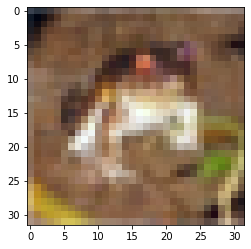

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

torchimage = train_set[0][0]
npimage=torchimage.permute(1,2,0)
npimage -= npimage.min()
npimage /= npimage.max()

plt.imshow(npimage)
plt.show()

(3, 274, 274)


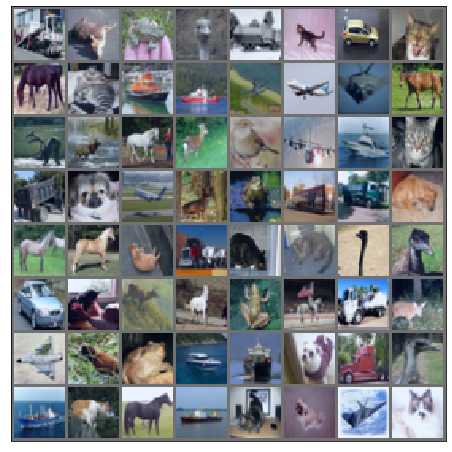

In [17]:
def imshow(img):
    im = torchvision.utils.make_grid(img)
    im -= im.min()
    im /= im.max()
    nping = im.numpy()
    print(nping.shape)
    plt.figure(figsize = (8,8))
    plt.imshow(np.transpose(nping, (1,2,0) ))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    
imshow(images)




In [18]:
#initialisation

def init_weight(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1: 
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [64]:
z_size = 100
input_size = 3072
hidden_size = 32
output_size = 1
n_c = 3

In [71]:
#Generator
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            #32*32*3
            nn.Conv2d(n_c , hidden_size , kernel_size = 4, stride = 2, padding = 1, bias = False),   #16*16*32
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),
            nn.Conv2d(hidden_size, hidden_size * 2 , kernel_size = 4, stride = 2, padding = 1, bias = False),  #8*8*64
            nn.BatchNorm2d(hidden_size * 2),
            nn.ReLU(True), nn.Conv2d(hidden_size  * 2 , hidden_size  * 4 , kernel_size = 4, stride = 2, padding = 1, bias = False),  #4*4*128
            nn.BatchNorm2d(hidden_size * 4),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_size * 4,hidden_size * 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(hidden_size *2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size * 2,hidden_size , kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(hidden_size ),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size , output_size ,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Sigmoid()
        )
    def forward(self, input):
        input = self.encoder(input)
        input = self.decoder(input)
        return input

In [72]:
A = Autoencoder()

A.apply(init_weight)




Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): B

In [73]:
def train(A, num_epoch = 5, batch_size = 64, learning_rate = 1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(A.parameters(), lr = learning_rate, weight_decay =1e-5)
    
    train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle = False,
    sampler = train_sampler, num_workers = 0,
    collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None
    )   


    outputs = []
    
    for epoch in range(num_epoch):
        for data in train_loader:
            img,_ = data
            recon = A(img)
            loss = criterion(recon, img)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
            
        print('Epoch : {}, Loss : {:,.4f}'.format (epoch + 1, float(loss)))
        outputs.append((epoch, img, recon),)
        
    return outputs

In [74]:
model = A
max_epoch = 15
outputs = train(A, num_epoch = max_epoch)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([64, 3, 32, 32])) that is different to the input size (torch.Size([64, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch : 1, Loss : 0.6868
Epoch : 2, Loss : 0.5820
Epoch : 3, Loss : 0.7020
Epoch : 4, Loss : 0.7305
Epoch : 5, Loss : 0.6753
Epoch : 6, Loss : 0.6813
Epoch : 7, Loss : 0.6724
Epoch : 8, Loss : 0.6466
Epoch : 9, Loss : 0.7032
Epoch : 10, Loss : 0.6665
Epoch : 11, Loss : 0.7489
Epoch : 12, Loss : 0.5978
Epoch : 13, Loss : 0.6541
Epoch : 14, Loss : 0.8293
Epoch : 15, Loss : 0.7366


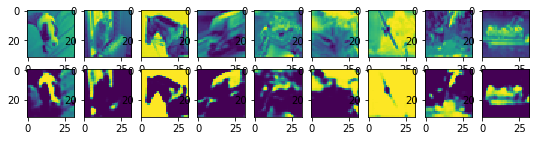

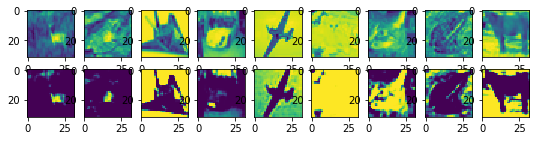

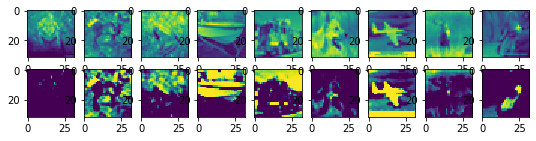

In [75]:
for k in range(0, max_epoch, 5):
    plt.figure(figsize = (9,2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >=9: break
        plt.subplot(2 , 9 , i + 1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >=9: break
        plt.subplot(2 , 9 , 9 + i + 1)
        plt.imshow(item[0])

 